## 银行违约预测
### 任务：预测是否违约

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from featexp import univariate_plotter  # pip install featexp
from featexp import get_univariate_plots
from featexp import get_trend_stats

In [2]:
# https://www.kaggle.com/c/home-credit-default-risk/data 数据集地址
application_raw = pd.read_csv('data/application_train.csv')  # 银行贷款数据，预测违约可能性0/1
application_raw.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# 数据预处理
def get_nonull_dummy_data(application_train_raw, dummy_drop=['ORGANIZATION_TYPE']):
    # 缺失值填充
    nulls = pd.isnull(application_train_raw).sum()
    less_nulls = nulls[(nulls<3075)&(nulls!=0)].index
    less_nulls_float = []
    for i in range(len(less_nulls)):
        if application_train_raw[less_nulls[i]].dtype != 'O':
            less_nulls_float.append(less_nulls[i])
            
    application_train_raw[less_nulls_float] = application_train_raw[less_nulls_float].fillna(application_train_raw[less_nulls_float].mean())
    
    # 缺失值填充
    more_nulls = nulls[(nulls >= 3075)].index
    more_nulls_float = []
    for i in range(len(more_nulls)):
        if application_train_raw[more_nulls[i]].dtype != 'O':
            more_nulls_float.append(more_nulls[i])
            
    application_train_raw[more_nulls_float] = application_train_raw[more_nulls_float].fillna(application_train_raw[more_nulls_float].mean())
    
    # 特征编码
    application_train_raw.drop(columns=dummy_drop, axis=1, inplace=True)
    
    all_cols = application_train_raw.columns
    cat_cols = []
    for col in all_cols:
        if application_train_raw[col].dtype == 'O':
            cat_cols.append(col)
            
    application_train_raw = pd.get_dummies(application_train_raw,columns=cat_cols, dummy_na=True)
    
    return application_train_raw


def import_and_create_train_test_data(test_size=0.33, random_state=42):
    # 训练和验证集制作
    application_raw = pd.read_csv('data/application_train.csv') 
    application = get_nonull_dummy_data(application_raw, dummy_drop=['ORGANIZATION_TYPE'])
    
    X = application.drop(['TARGET'],axis=1)
    y = application['TARGET']
    X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=test_size,random_state=random_state)
    
    train_users = X_train[['SK_ID_CURR']]
    train_users['TARGET'] = y_train
    test_users = X_test[['SK_ID_CURR']]
    test_users['TARGET'] = y_test
    train_users.reset_index(drop=True, inplace=True)
    test_users.reset_index(drop=True, inplace=True)
    
    return(X_train, X_test,y_train,y_test,train_users,test_users)


def import_and_create_TEST_data():
    # 线上测试集
    application_raw = pd.read_csv('data/application_test.csv') 
    application = get_nonull_dummy_data(application_raw, dummy_drop=['ORGANIZATION_TYPE'])
  
    X = application
    users = X[['SK_ID_CURR']]
    users.reset_index(drop=True, inplace=True)
    
    return(X, users)


def get_imp_df(xgb_model):
# 获取特征重要性
    imp = pd.DataFrame(np.asarray(list(xgb_model.get_fscore().keys())))
    imp.columns = ['Feature']
    imp['importance'] = np.asarray(list(xgb_model.get_fscore().keys()))
    imp = imp.sort_values(by=['importance'], ascending=False)
    imp = imp.reset_index(drop=True)
    
    return (imp)

### 训练集和验证集

In [4]:
X_train, X_test, y_train,y_test,train_users,test_users = import_and_create_train_test_data()
X_TEST,TEST_users = import_and_create_TEST_data()

drop=['CODE_GENDER_XNA','NAME_INCOME_TYPE_Maternity leave',
      'NAME_FAMILY_STATUS_Unknown','SK_ID_CURR']
X_train = X_train.drop(drop, axis=1)
X_test = X_test.drop(drop, axis=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
data_train = X_train.reset_index(drop=True)
data_train['target'] = y_train.reset_index(drop=True)
data_test = X_test.reset_index(drop=True)
data_test['target'] = y_test.reset_index(drop=True)

                                        Plots for CNT_CHILDREN                                        
                                           Train data plots                                           


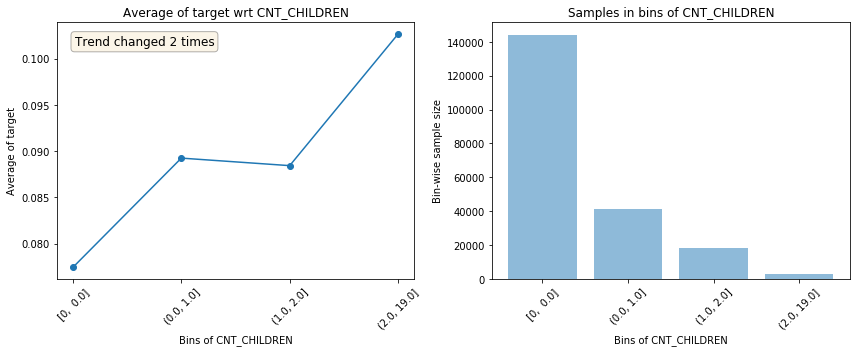

                                           Test data plots                                            


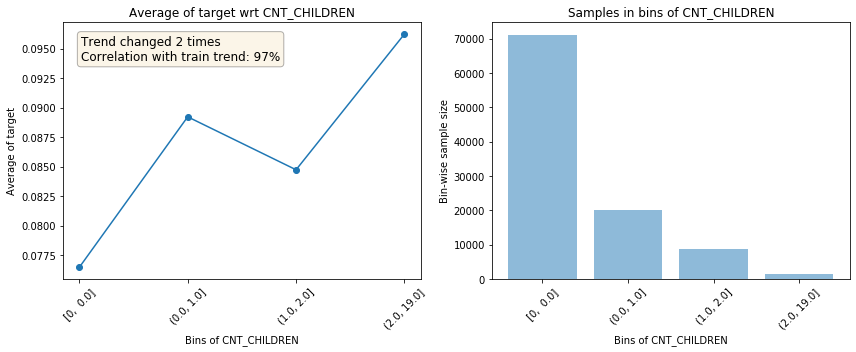

--------------------------------------------------------------------------------------------------------------


                                      Plots for AMT_INCOME_TOTAL                                      
                                           Train data plots                                           


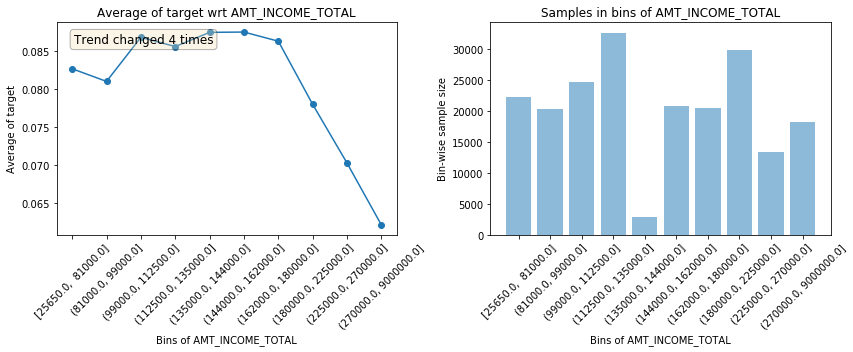

                                           Test data plots                                            


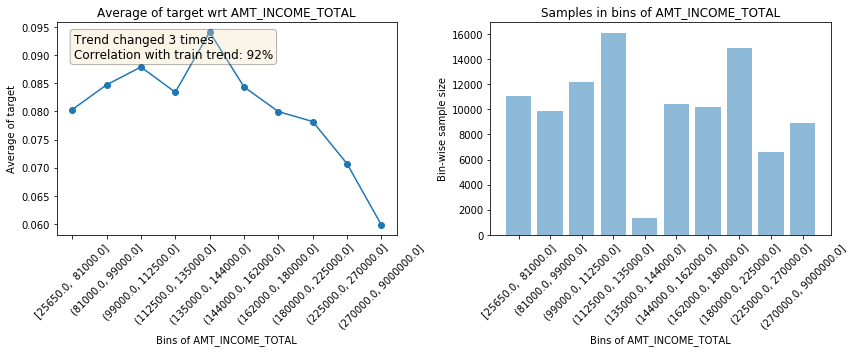

--------------------------------------------------------------------------------------------------------------


                                         Plots for AMT_CREDIT                                         
                                           Train data plots                                           


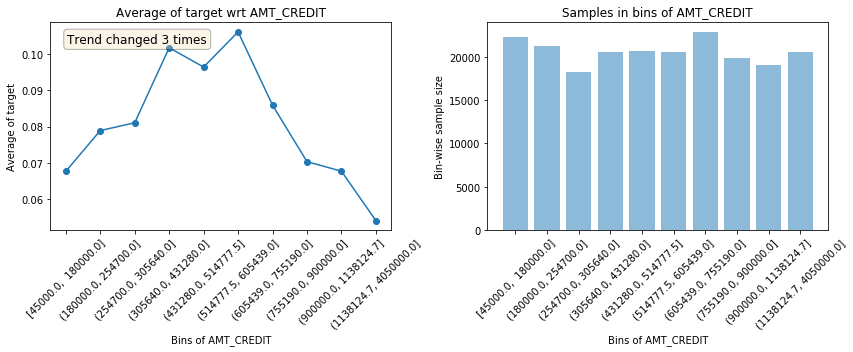

                                           Test data plots                                            


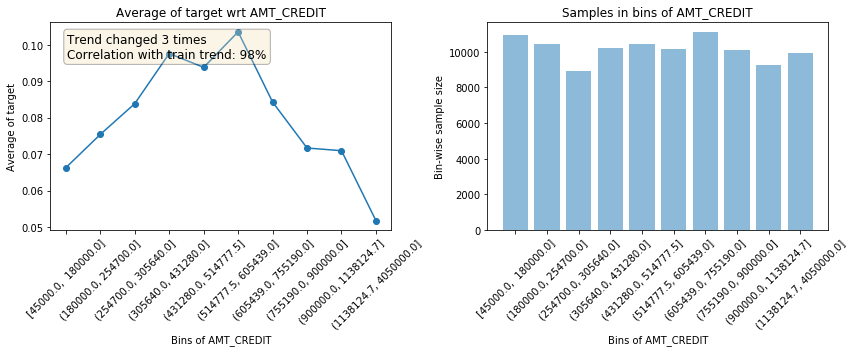

--------------------------------------------------------------------------------------------------------------


                                        Plots for AMT_ANNUITY                                         
                                           Train data plots                                           


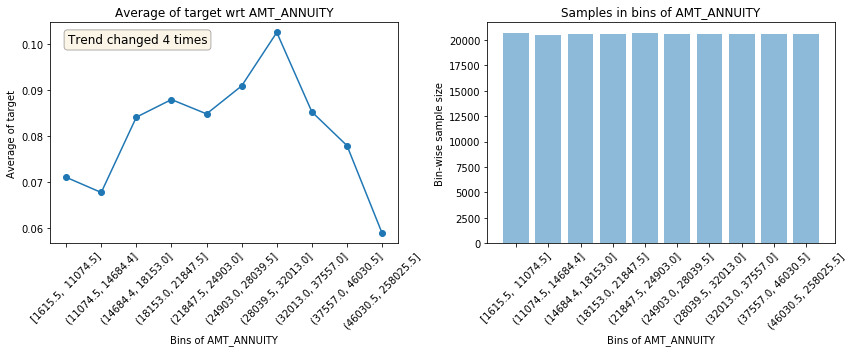

                                           Test data plots                                            


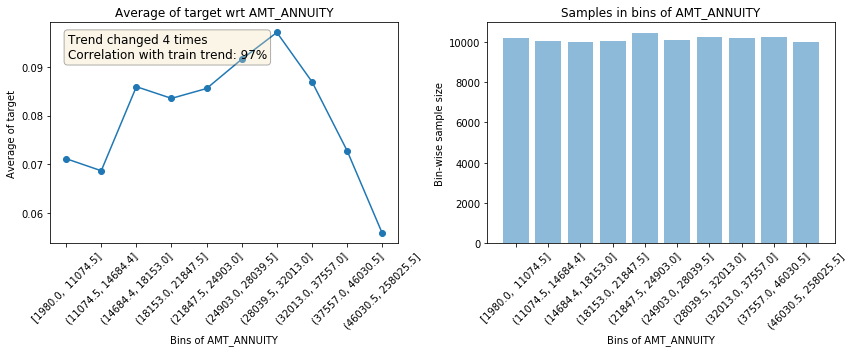

--------------------------------------------------------------------------------------------------------------


                                      Plots for AMT_GOODS_PRICE                                       
                                           Train data plots                                           


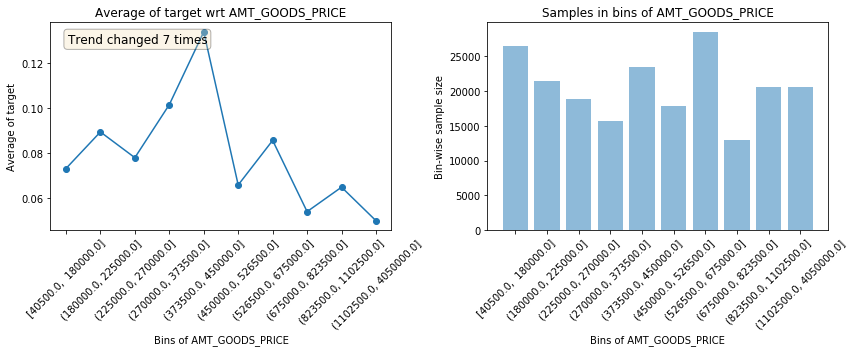

                                           Test data plots                                            


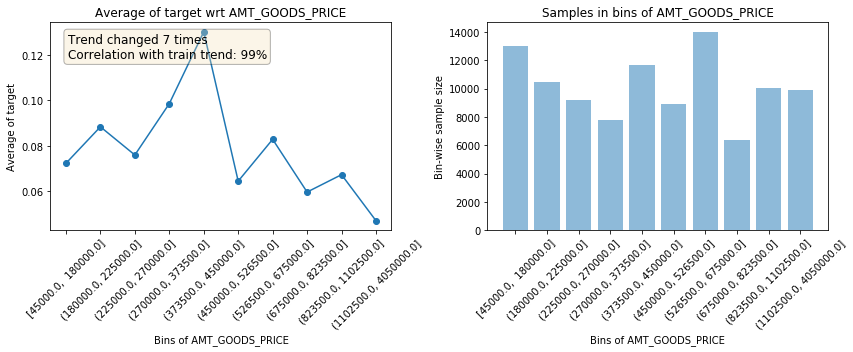

--------------------------------------------------------------------------------------------------------------


                                 Plots for REGION_POPULATION_RELATIVE                                 
                                           Train data plots                                           


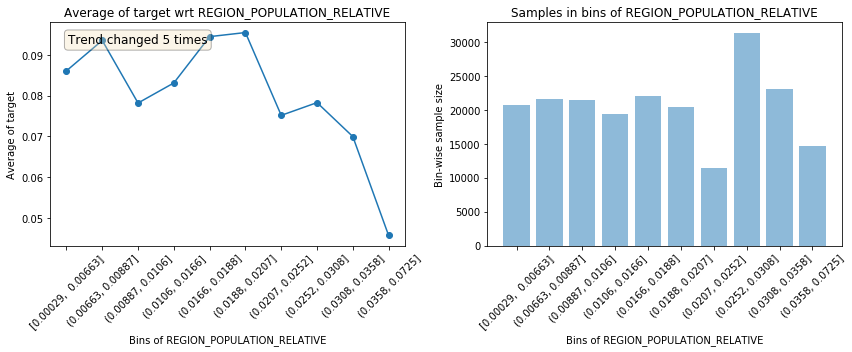

                                           Test data plots                                            


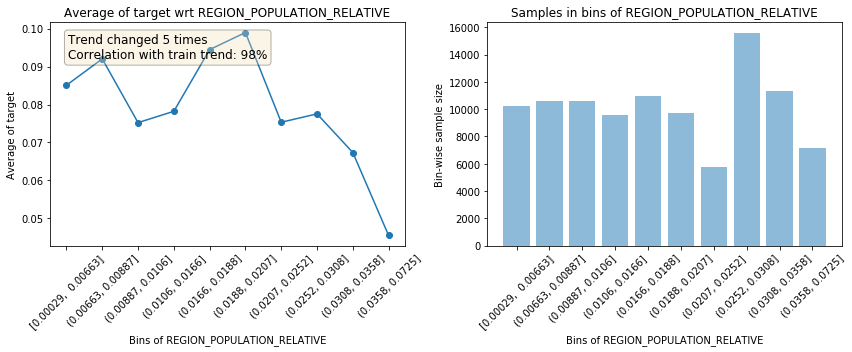

--------------------------------------------------------------------------------------------------------------


                                         Plots for DAYS_BIRTH                                         
                                           Train data plots                                           


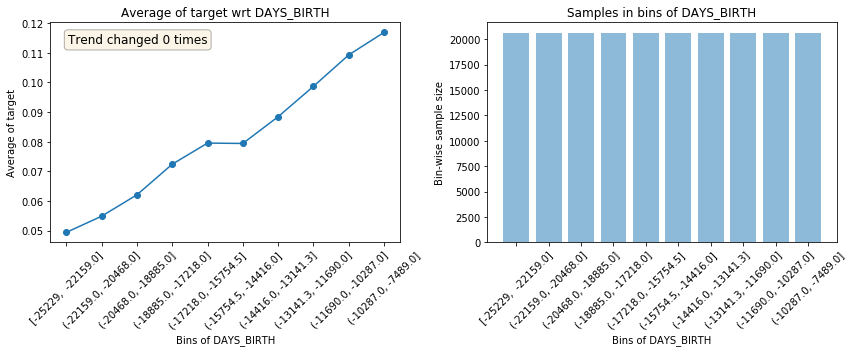

                                           Test data plots                                            


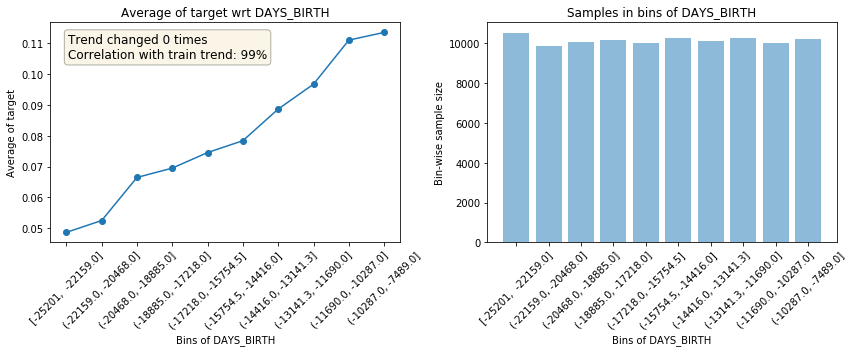

--------------------------------------------------------------------------------------------------------------


                                       Plots for DAYS_EMPLOYED                                        
                                           Train data plots                                           


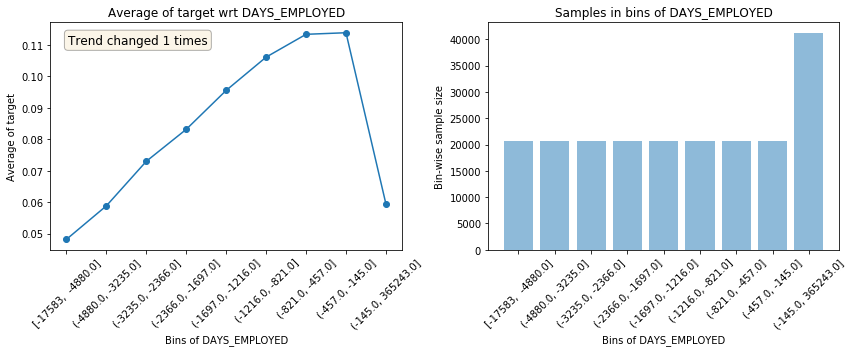

                                           Test data plots                                            


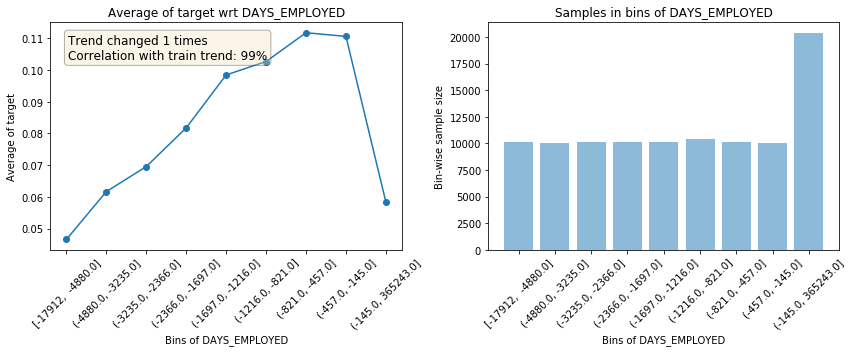

--------------------------------------------------------------------------------------------------------------


                                     Plots for DAYS_REGISTRATION                                      
                                           Train data plots                                           


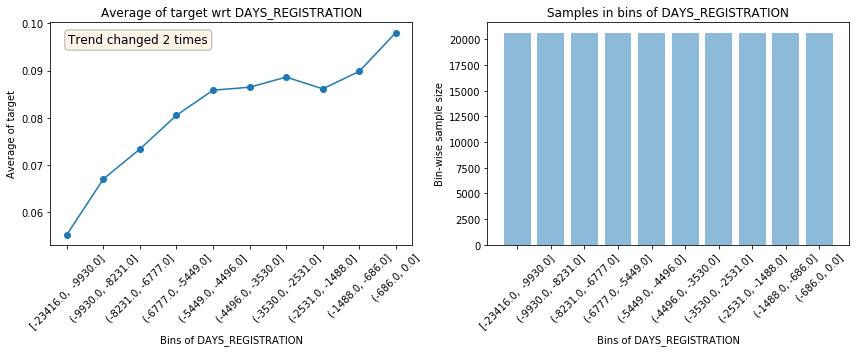

                                           Test data plots                                            


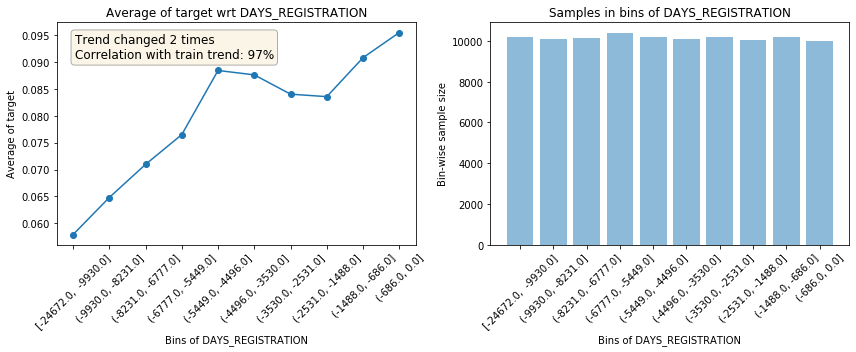

--------------------------------------------------------------------------------------------------------------


                                      Plots for DAYS_ID_PUBLISH                                       
                                           Train data plots                                           


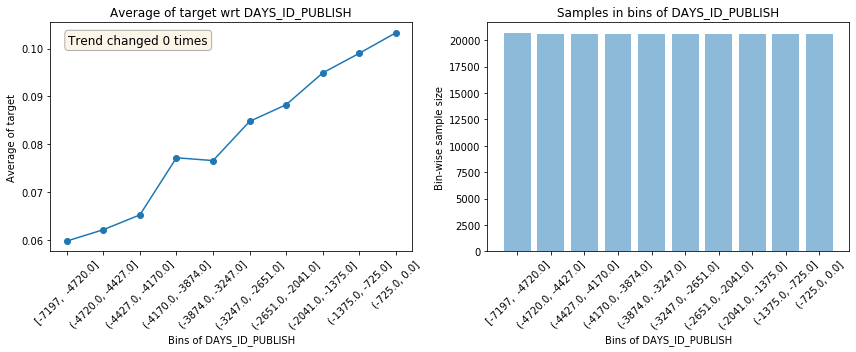

                                           Test data plots                                            


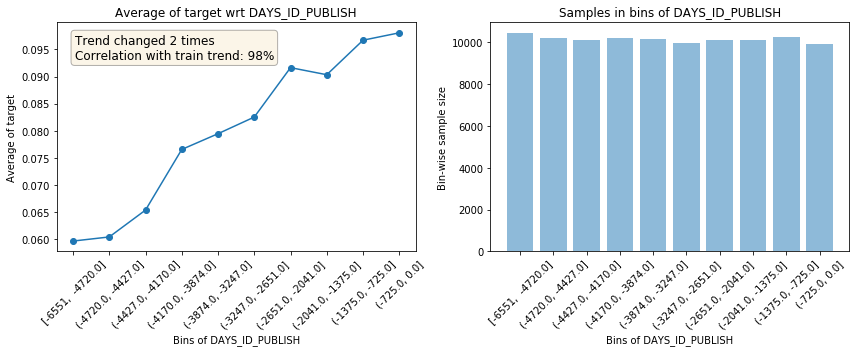

--------------------------------------------------------------------------------------------------------------




In [6]:
# 训练集与验证集特征趋势分析


get_univariate_plots(data=data_train,target_col='target',
                     features_list=data_train.columns[0:10],data_test=data_test)


                                      Plots for AMT_INCOME_TOTAL                                      
                                           Train data plots                                           


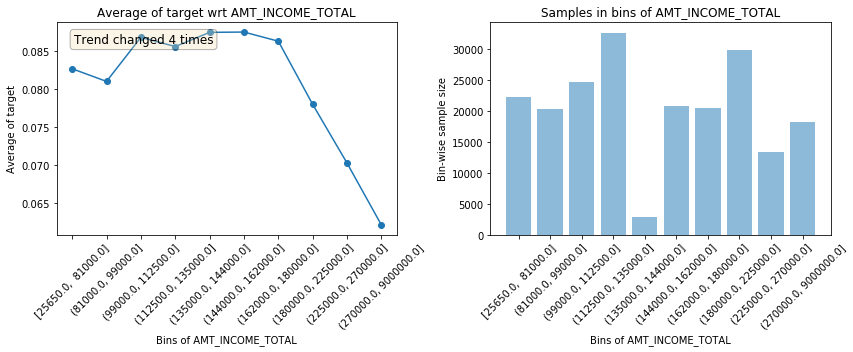

                                           Test data plots                                            


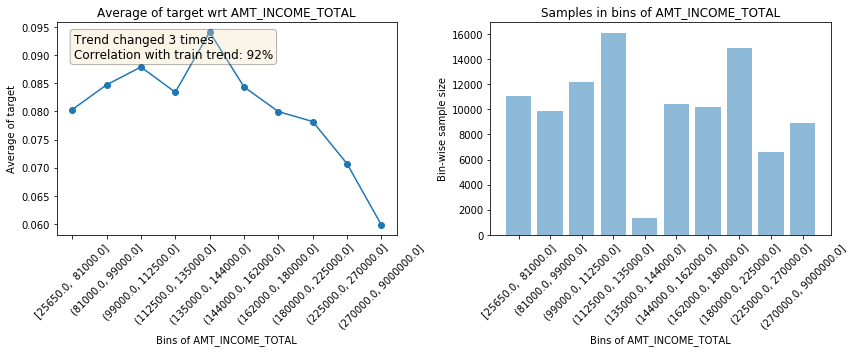

--------------------------------------------------------------------------------------------------------------




In [7]:
grouped_train,grouped_test = univariate_plotter(data=data_train,
                                                target_col='target',
                                                feature='AMT_INCOME_TOTAL',
                                                data_test=data_test)

In [8]:
grouped_train  # 展示bin中数据信息

,AMT_INCOME_TOTAL,Samples_in_bin,target_mean,AMT_INCOME_TOTAL_mean
0,"[25650.0, 81000.0]",22334,0.082699,66257.130366
1,"(81000.0, 99000.0]",20424,0.081032,91076.626816
2,"(99000.0, 112500.0]",24746,0.086842,111311.671092
3,"(112500.0, 135000.0]",32725,0.085623,131844.069914
4,"(135000.0, 144000.0]",2846,0.087491,142867.813598
5,"(144000.0, 162000.0]",20804,0.087531,157082.746126
6,"(162000.0, 180000.0]",20550,0.086326,178073.976044
7,"(180000.0, 225000.0]",29937,0.077997,212795.095082
8,"(225000.0, 270000.0]",13392,0.070266,259515.009845
9,"(270000.0, 9000000.0]",18274,0.062110,389590.875377


### 训练模型，使用全部特征

In [9]:
dtrain = xgb.DMatrix(X_test,label=y_test,missing=np.nan)
dtest = xgb.DMatrix(X_train,label=y_train,missing=np.nan)

params = {'max_depth':8,'learning_rate':0.1,'silent':0,
          'objective':'binary:logistic','min_child_weight':500,
         'eval_metric':'auc','nthread':8}
xgb_model = xgb.train(params, dtrain, 400, evals=[(dtrain,'train'),
                                                 (dtest,'test')],
                     early_stopping_rounds=25)

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.719563	test-auc:0.709598
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.724945	test-auc:0.713941
[2]	train-auc:0.726312	test-auc:0.715967
[3]	train-auc:0.729903	test-auc:0.71897
[4]	train-auc:0.730465	test-auc:0.719138
[5]	train-auc:0.733149	test-auc:0.721291
[6]	train-auc:0.734225	test-auc:0.722095
[7]	train-auc:0.734966	test-auc:0.722414
[8]	train-auc:0.735452	test-auc:0.723238
[9]	train-auc:0.736324	test-auc:0.723958
[10]	train-auc:0.736488	test-auc:0.723896
[11]	train-auc:0.73694	test-auc:0.724179
[12]	train-auc:0.736669	test-auc:0.723926
[13]	train-auc:0.737064	test-auc:0.724415
[14]	train-auc:0.737568	test-auc:0.724846
[15]	train-auc:0.737548	test-auc:0.725108
[16]	train-auc:0.738029	test-auc:0.725516
[17]	train-auc:0.738283	test-auc:0.725743
[18]	train-auc:0.738371	test-auc:0.725703
[19]	train-auc:0.738665	test-auc:0.725989
[20]	train-auc:0.739185	test-au

[191]	train-auc:0.782668	test-auc:0.754421
[192]	train-auc:0.782786	test-auc:0.754437
[193]	train-auc:0.78289	test-auc:0.754435
[194]	train-auc:0.782993	test-auc:0.754461
[195]	train-auc:0.7831	test-auc:0.754447
[196]	train-auc:0.783196	test-auc:0.754449
[197]	train-auc:0.783306	test-auc:0.754448
[198]	train-auc:0.783452	test-auc:0.754466
[199]	train-auc:0.783572	test-auc:0.754471
[200]	train-auc:0.783632	test-auc:0.754493
[201]	train-auc:0.783718	test-auc:0.754509
[202]	train-auc:0.783805	test-auc:0.754511
[203]	train-auc:0.783905	test-auc:0.754472
[204]	train-auc:0.78397	test-auc:0.754495
[205]	train-auc:0.784032	test-auc:0.754505
[206]	train-auc:0.784146	test-auc:0.754525
[207]	train-auc:0.784268	test-auc:0.754525
[208]	train-auc:0.784392	test-auc:0.754496
[209]	train-auc:0.784479	test-auc:0.754511
[210]	train-auc:0.784601	test-auc:0.754505
[211]	train-auc:0.784714	test-auc:0.754516
[212]	train-auc:0.784796	test-auc:0.754519
[213]	train-auc:0.784871	test-auc:0.754507
[214]	train-auc

In [10]:
# 提交结果
dTEST = xgb.DMatrix(X_TEST[X_test.columns], missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_all_feats = pd.DataFrame({'SK_ID_CURR':TEST_users['SK_ID_CURR'],
                                    'TARGET':y_TEST_pred})
submission_all_feats.to_csv('data/submission_all_feats_1.csv',index=False)

In [13]:
submission_all_feats.shape

(48744, 2)

### 提交
<img src="assets/20201211223355.png" width="70%">
<img src="assets/20201211225336.png" width="70%">
上传后，点击Make Submission，就可以看到结果了
<img src="assets/20201211223521.png" width="70%">

### 计算训练集和验证集中特征的趋势

In [11]:
stats = get_trend_stats(data=data_train,target_col='target',data_test=data_test)

Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Only one bin created for NAME_CONTRACT_TYPE_Cash loans. Correlation can't be calculated
Only one bin created for NAME_CONTRACT_TYPE_nan. Correlation can't be calculated
Only one bin created for CODE_GENDER_nan. Correlation can't be calculated
Only one bin created for FLAG_OWN_CAR_nan. Correlation can't be calculated
Only one bin created for FLAG_OWN_REALTY_nan. Correlation can't be calculated
Only one bin created for NAME_INCOME_TYPE_nan. Correlation can't be calculated
Only one bin created for NAME_EDUCATION_TYPE_nan. Correlation can't be calculated
Only one bin created for NAME_FAMILY_STATUS_nan. Correlation can't be calculated
Only one bin created for NAME_HOUSING_TYPE_nan. Correlation can't be calculated
Only one bin created for WEEKDAY_APPR_PROCESS_START_nan. Correlation can't be calculated
Returning stats for all numeric features


In [14]:
stats  # Trend_changes训练集中变化趋势，Trend_changes_test测试集中变化取时，Trend_correlation训练和验证的相关度

,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,CNT_CHILDREN,2,2,0.975688
1,AMT_INCOME_TOTAL,4,3,0.921382
2,AMT_CREDIT,3,3,0.988779
3,AMT_ANNUITY,4,4,0.972325
4,AMT_GOODS_PRICE,7,7,0.994683
5,REGION_POPULATION_RELATIVE,5,5,0.989683
6,DAYS_BIRTH,0,0,0.992783
7,DAYS_EMPLOYED,1,1,0.995426
8,DAYS_REGISTRATION,2,2,0.976891
9,DAYS_ID_PUBLISH,0,2,0.985101


In [15]:
# 添加特征重要性
importance_df = get_imp_df(xgb_model)
stats = pd.merge(stats, importance_df, how='left', on='Feature')
stats['importance'] = stats['importance'].fillna(0)

### 剔除掉相关性（训练与测试）< 0.95的特征

In [16]:
noisy = list(stats[stats['Trend_correlation']<0.95]['Feature'])
dtrain = xgb.DMatrix(X_test.drop(noisy,axis=1),label=y_test,missing=np.nan)
dtest = xgb.DMatrix(X_train.drop(noisy,axis=1),label=y_train,missing=np.nan)

params = {'max_depth':8,'learning_rate':0.1,'silent':0,
          'objective':'binary:logistic','min_child_weight':500,
         'eval_metric':'auc','nthread':8}
xgb_model = xgb.train(params, dtrain, 400, evals=[(dtrain,'train'),
                                                 (dtest,'test')],
                     early_stopping_rounds=25)

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.719563	test-auc:0.709598
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.724939	test-auc:0.714084
[2]	train-auc:0.726316	test-auc:0.716055
[3]	train-auc:0.729857	test-auc:0.719014
[4]	train-auc:0.731781	test-auc:0.720706
[5]	train-auc:0.732261	test-auc:0.720638
[6]	train-auc:0.733963	test-auc:0.721684
[7]	train-auc:0.734645	test-auc:0.722206
[8]	train-auc:0.735698	test-auc:0.722972
[9]	train-auc:0.736051	test-auc:0.723388
[10]	train-auc:0.736517	test-auc:0.723679
[11]	train-auc:0.736583	test-auc:0.723835
[12]	train-auc:0.736712	test-auc:0.723897
[13]	train-auc:0.736697	test-auc:0.723828
[14]	train-auc:0.737352	test-auc:0.724653
[15]	train-auc:0.737329	test-auc:0.724729
[16]	train-auc:0.737736	test-auc:0.725029
[17]	train-auc:0.73797	test-auc:0.725215
[18]	train-auc:0.7385	test-auc:0.725745
[19]	train-auc:0.738508	test-auc:0.725741
[20]	train-auc:0.7396	test-auc:0

[191]	train-auc:0.78096	test-auc:0.754173
[192]	train-auc:0.781073	test-auc:0.754227
[193]	train-auc:0.781145	test-auc:0.754244
[194]	train-auc:0.781223	test-auc:0.754244
[195]	train-auc:0.781303	test-auc:0.754249
[196]	train-auc:0.781405	test-auc:0.754247
[197]	train-auc:0.78149	test-auc:0.75429
[198]	train-auc:0.781594	test-auc:0.754316
[199]	train-auc:0.781692	test-auc:0.75438
[200]	train-auc:0.781769	test-auc:0.754414
[201]	train-auc:0.781891	test-auc:0.754432
[202]	train-auc:0.781976	test-auc:0.75447
[203]	train-auc:0.782069	test-auc:0.754445
[204]	train-auc:0.782166	test-auc:0.75443
[205]	train-auc:0.782269	test-auc:0.754432
[206]	train-auc:0.782382	test-auc:0.754457
[207]	train-auc:0.782459	test-auc:0.754481
[208]	train-auc:0.782548	test-auc:0.754479
[209]	train-auc:0.782654	test-auc:0.75447
[210]	train-auc:0.782717	test-auc:0.754491
[211]	train-auc:0.782848	test-auc:0.754512
[212]	train-auc:0.782967	test-auc:0.754507
[213]	train-auc:0.783017	test-auc:0.754527
[214]	train-auc:0.

In [20]:
dTEST = xgb.DMatrix(X_TEST[X_test.columns].drop(noisy, axis=1), missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_all_feats = pd.DataFrame({'SK_ID_CURR':TEST_users['SK_ID_CURR'],
                                    'TARGET':y_TEST_pred})
submission_all_feats.to_csv('data/submission_95_1.csv',index=False)

### 剔除掉相关性（训练与测试）< 0.90的特征

In [21]:
noisy = list(stats[stats['Trend_correlation']<0.90]['Feature'])
dtrain = xgb.DMatrix(X_test.drop(noisy,axis=1),label=y_test,missing=np.nan)
dtest = xgb.DMatrix(X_train.drop(noisy,axis=1),label=y_train,missing=np.nan)

params = {'max_depth':8,'learning_rate':0.1,'silent':0,
          'objective':'binary:logistic','min_child_weight':500,
         'eval_metric':'auc','nthread':8}
xgb_model = xgb.train(params, dtrain, 400, evals=[(dtrain,'train'),
                                                 (dtest,'test')],
                     early_stopping_rounds=25)

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.719563	test-auc:0.709598
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.724945	test-auc:0.713941
[2]	train-auc:0.726312	test-auc:0.715967
[3]	train-auc:0.729903	test-auc:0.71897
[4]	train-auc:0.730465	test-auc:0.719138
[5]	train-auc:0.733149	test-auc:0.721291
[6]	train-auc:0.734225	test-auc:0.722095
[7]	train-auc:0.734966	test-auc:0.722414
[8]	train-auc:0.735452	test-auc:0.723238
[9]	train-auc:0.736324	test-auc:0.723958
[10]	train-auc:0.736488	test-auc:0.723896
[11]	train-auc:0.73694	test-auc:0.724179
[12]	train-auc:0.736669	test-auc:0.723926
[13]	train-auc:0.737064	test-auc:0.724415
[14]	train-auc:0.737568	test-auc:0.724846
[15]	train-auc:0.737548	test-auc:0.725108
[16]	train-auc:0.738029	test-auc:0.725516
[17]	train-auc:0.738283	test-auc:0.725743
[18]	train-auc:0.738371	test-auc:0.725703
[19]	train-auc:0.738665	test-auc:0.725989
[20]	train-auc:0.739185	test-au

[191]	train-auc:0.782536	test-auc:0.754277
[192]	train-auc:0.782666	test-auc:0.754302
[193]	train-auc:0.782763	test-auc:0.754335
[194]	train-auc:0.782897	test-auc:0.754367
[195]	train-auc:0.782992	test-auc:0.754368
[196]	train-auc:0.783104	test-auc:0.754336
[197]	train-auc:0.783164	test-auc:0.754333
[198]	train-auc:0.78324	test-auc:0.754364
[199]	train-auc:0.783373	test-auc:0.754374
[200]	train-auc:0.783458	test-auc:0.754386
[201]	train-auc:0.783527	test-auc:0.754359
[202]	train-auc:0.783622	test-auc:0.754355
[203]	train-auc:0.783719	test-auc:0.754327
[204]	train-auc:0.783785	test-auc:0.75428
[205]	train-auc:0.783911	test-auc:0.754299
[206]	train-auc:0.783975	test-auc:0.754326
[207]	train-auc:0.784023	test-auc:0.754354
[208]	train-auc:0.784118	test-auc:0.754376
[209]	train-auc:0.78425	test-auc:0.754398
[210]	train-auc:0.784343	test-auc:0.754441
[211]	train-auc:0.78442	test-auc:0.754507
[212]	train-auc:0.78452	test-auc:0.754515
[213]	train-auc:0.784638	test-auc:0.75456
[214]	train-auc:0

In [22]:
dTEST = xgb.DMatrix(X_TEST[X_test.columns].drop(noisy, axis=1), missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_all_feats = pd.DataFrame({'SK_ID_CURR':TEST_users['SK_ID_CURR'],
                                    'TARGET':y_TEST_pred})
submission_all_feats.to_csv('data/submission_90_1.csv',index=False)

### 剔除掉相关性（训练与测试）< 0.95的特征 并且 提取钱40个特征重要性排名特征

In [34]:
noisy = list(stats[(stats['Trend_correlation']<0.95) & (stats['importance'].head(40))]['Feature'])
             
dtrain = xgb.DMatrix(X_test.drop(noisy,axis=1),label=y_test,missing=np.nan)
dtest = xgb.DMatrix(X_train.drop(noisy,axis=1),label=y_train,missing=np.nan)

params = {'max_depth':10,'learning_rate':0.25,'silent':0,
          'objective':'binary:logistic','min_child_weight':500,
         'eval_metric':'auc','nthread':8}
xgb_model = xgb.train(params, dtrain, 200, evals=[(dtrain,'train'),
                                                 (dtest,'test')],
                     early_stopping_rounds=25)

[0]	train-auc:0.719563	test-auc:0.709598
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.72923	test-auc:0.717799
[2]	train-auc:0.732231	test-auc:0.720414
[3]	train-auc:0.735095	test-auc:0.723335
[4]	train-auc:0.735236	test-auc:0.723445
[5]	train-auc:0.735597	test-auc:0.723573
[6]	train-auc:0.736047	test-auc:0.724205
[7]	train-auc:0.736781	test-auc:0.724746
[8]	train-auc:0.738945	test-auc:0.72673
[9]	train-auc:0.740371	test-auc:0.727869
[10]	train-auc:0.741709	test-auc:0.729452
[11]	train-auc:0.743634	test-auc:0.730992
[12]	train-auc:0.744828	test-auc:0.732181
[13]	train-auc:0.747124	test-auc:0.733979
[14]	train-auc:0.749695	test-auc:0.736317
[15]	train-auc:0.751257	test-auc:0.737707
[16]	train-auc:0.752213	test-auc:0.738447
[17]	train-auc:0.753662	test-auc:0.739679
[18]	train-auc:0.755395	test-auc:0.741069
[19]	train-auc:0.756904	test-auc:0.742041
[20]	train-auc:0.757682	test-au

In [ ]:
dTEST = xgb.DMatrix(X_TEST[X_test.columns].drop(noisy, axis=1), missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_all_feats = pd.DataFrame({'SK_ID_CURR':TEST_users['SK_ID_CURR'],
                                    'TARGET':y_TEST_pred})
submission_all_feats.to_csv('data/submission_95_40_1.csv',index=False)

通过修改、提交，来不断提高分数，以下是各种情况下的结果：
<img src="assets/20201211231030.png" width="70%">